In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

In [3]:
from omegaconf import OmegaConf
from paintmind.engine.util import instantiate_from_config
import torch

In [4]:
cfg = 'configs/dit_enc_rgb_woof_ar_exp_large.yaml'
cfg = OmegaConf.load(cfg)

In [5]:
cfg['trainer']['params']['model']['params']['ckpt_path'] = \
'output/dit_woof_3460ep_enable_after_3400ep_noln/models/step485000/'

In [6]:
cfg

{'trainer': {'target': 'paintmind.engine.trainer.DiffusionTrainer', 'params': {'num_epoch': 3460, 'valid_size': 64, 'lr': 0.00035, 'lr_min': 5e-05, 'warmup_steps': 2000, 'warmup_lr_init': 1e-06, 'decay_steps': 25000, 'batch_size': 32, 'num_workers': 32, 'pin_memory': True, 'grad_accum_steps': 1, 'mixed_precision': 'bf16', 'max_grad_norm': 3.0, 'save_every': 5000, 'sample_every': 5000, 'result_folder': 'output/dit_woof_3460ep_enable_after_3400ep_noln', 'log_dir': 'output/dit_woof_3460ep_enable_after_3400ep_noln/logs', 'model': {'target': 'paintmind.stage1.diffuse_slot.DiffuseSlot', 'params': {'slot_dim': 8, 'num_slots': 64, 'num_samplers': 64, 'sampler_dim': 8, 'cond_method': 'token', 'dit_model': 'DiT-XL-2', 'vae': 'stabilityai/sd-vae-ft-ema', 'enable_nest': False, 'enable_nest_after': 3400, 'nest_rho': 0.03, 'nest_dist': 'uniform', 'use_encoder_rgb': True, 'encoder': 'vit_base_patch16', 'enc_img_size': 256, 'eval_fid': True, 'fid_stats': 'fid_stats/adm_in256_stats.npz', 'ckpt_path': '

In [7]:
trainer = instantiate_from_config(cfg.trainer)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/mnt/ceph_rbd/zbc/slot_ar/paintmind/stage1/diffuse_slot.py:233: FutureWarning: Accessing config attribute `scaling_factor` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'scaling_factor' over 'AutoencoderKL's config object instead, e.g. 'unet.config.scaling_factor'.
  self.scaling_factor = self.vae.scaling_factor


train dataset size: 8961, valid dataset size: 64
number of learnable parameters: 760.0M


In [8]:
trainer.eval_fid = True

In [9]:
trainer.fid_stats = 'fid_stats/adm_in256_stats.npz'

In [10]:
metrics = trainer.evaluate(return_metrics=True)

  0%|                                                                                                    | 0/2…

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/mnt/ceph_rbd/zbc/miniconda3/envs/llavapp/lib/python3.11/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)


In [11]:
metrics

{'inception_score_mean': 4.156632293188033,
 'inception_score_std': 0.6066615589525801,
 'frechet_inception_distance': 94.75317074269259}

In [12]:
def norm_ip(img, low, high):
    img.clamp_(min=low, max=high)
    img.sub_(low).div_(max(high - low, 1e-5))

def norm_range(t, value_range):
    if value_range is not None:
        norm_ip(t, value_range[0], value_range[1])
    else:
        norm_ip(t, float(t.min()), float(t.max()))

In [13]:
from PIL import Image
def convert_np(img):
    ndarr = img.mul(255).add_(0.5).clamp_(0, 255)\
            .permute(1, 2, 0).to("cpu", torch.uint8).numpy()
    return ndarr
def convert_PIL(img):
    ndarr = img.mul(255).add_(0.5).clamp_(0, 255)\
            .permute(1, 2, 0).to("cpu", torch.uint8).numpy()
    img = Image.fromarray(ndarr)
    return img

In [14]:
trainer.vqvae.eval()
with torch.no_grad():
    for batch in trainer.valid_dl:
        img = batch[0].tensors
        rec64 = trainer.vqvae(img, None, sample=True, inference_with_n_slots=64)
        rec60 = trainer.vqvae(img, None, sample=True, inference_with_n_slots=60)
        rec32 = trainer.vqvae(img, None, sample=True, inference_with_n_slots=32)
        rec8 = trainer.vqvae(img, None, sample=True, inference_with_n_slots=8)
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
for i in range(img.size(0)):
    norm_range(img[i], (0, 1))
    norm_range(rec64[i], (0, 1))
    norm_range(rec60[i], (0, 1))
    norm_range(rec32[i], (0, 1))
    norm_range(rec8[i], (0, 1))

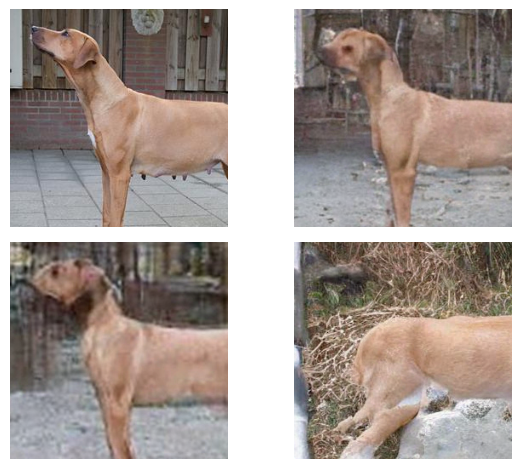

In [16]:
idx = 1


plt.subplot(2, 2, 1)

plt.imshow(convert_np(img[idx]))
plt.axis('off')

plt.subplot(2, 2, 2)

plt.imshow(convert_np(rec64[idx]))
plt.axis('off')

plt.subplot(2, 2, 3)

plt.imshow(convert_np(rec32[idx]))
plt.axis('off')

plt.subplot(2, 2, 4)

plt.imshow(convert_np(rec8[idx]))
plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
len(trainer.train_dl)

281

In [28]:
_cnt = 0
slots = []
with torch.no_grad():
    for batch in trainer.train_dl:
        _cnt += 1
        if _cnt >= 33:
            break
        img = batch[0].tensors
        slot = trainer.vqvae.encoder(img)
        slot = trainer.vqvae.encoder2slot(slot)
        slot, _ = trainer.vqvae.grouping(slot)
        slots.append(slot.cpu())
slots = torch.cat(slots, dim=0)

In [29]:
slots.shape

torch.Size([1024, 64, 8])

In [30]:
torch.save(slots, 'example_slot_cache.pth')

In [33]:
next(iter(trainer.train_dl))[0].tensors.shape

torch.Size([32, 3, 256, 256])

In [36]:
from tqdm.notebook import tqdm

In [42]:
with torch.no_grad():
    sampled_slots64 = []
    sampled_slots32 = []
    sampled_slots8 = []
    labels = []
    for batch in tqdm(trainer.train_dl):
        img = batch[0].tensors
        label = batch[1]
        sampled_slots64.append(trainer.vqvae.encode_to_sampler(img, n_slots=64).cpu())
        sampled_slots32.append(trainer.vqvae.encode_to_sampler(img, n_slots=32).cpu())
        sampled_slots8.append(trainer.vqvae.encode_to_sampler(img, n_slots=8).cpu())
        labels.append(torch.tensor(label))
    sampled_slots64 = torch.cat(sampled_slots64, dim=0)
    sampled_slots32 = torch.cat(sampled_slots32, dim=0)
    sampled_slots8 = torch.cat(sampled_slots8, dim=0)
    labels = torch.cat(labels, dim=0)
sampled_slots64.shape, sampled_slots32.shape, sampled_slots8.shape, labels.shape

  0%|          | 0/281 [00:00<?, ?it/s]

(torch.Size([8961, 64, 8]),
 torch.Size([8961, 32, 8]),
 torch.Size([8961, 8, 8]),
 torch.Size([8961]))

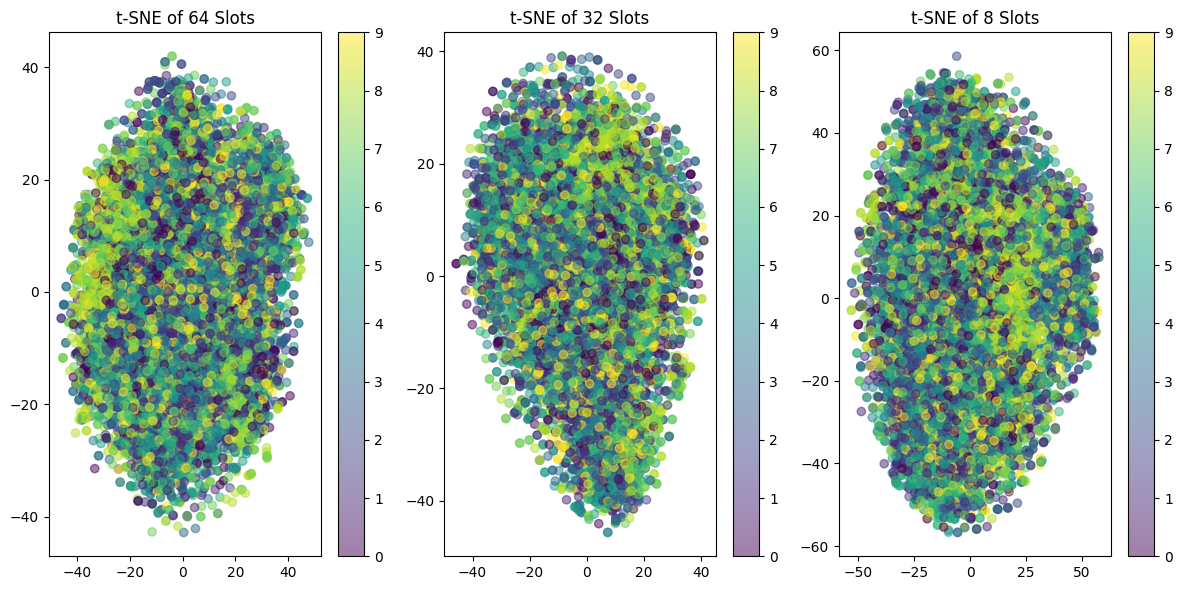

In [43]:
# run tsne on sampled_slots64, sampled_slots32, sampled_slots8, labels
from sklearn.manifold import TSNE
tsne64 = TSNE(n_components=2, random_state=42)
tsne32 = TSNE(n_components=2, random_state=42)
tsne8 = TSNE(n_components=2, random_state=42)

embeddings64 = tsne64.fit_transform(sampled_slots64.view(sampled_slots64.size(0), -1))
embeddings32 = tsne32.fit_transform(sampled_slots32.view(sampled_slots32.size(0), -1))
embeddings8 = tsne8.fit_transform(sampled_slots8.view(sampled_slots8.size(0), -1))

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(embeddings64[:, 0], embeddings64[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.title('t-SNE of 64 Slots')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(embeddings32[:, 0], embeddings32[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.title('t-SNE of 32 Slots')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(embeddings8[:, 0], embeddings8[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.title('t-SNE of 8 Slots')
plt.colorbar()

plt.tight_layout()
plt.show()


In [38]:
from paintmind.stage1.diffloss import DiffLoss
from timm.models.vision_transformer import LayerScale, DropPath, Mlp

In [39]:
class CausalAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def create_causal_mask(self, seq_len):
        mask = torch.triu(
            torch.ones(seq_len, seq_len), diagonal=1
        )
        return mask.unsqueeze(0).unsqueeze(0)
    
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        mask = self.create_causal_mask(N).to(x.device)
        attn = attn.masked_fill(
            mask == 1, float("-inf")
        )  # apply mask by setting masked positions to -infinity
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [40]:
class CausalBlock(nn.Module):
    def __init__(
            self,
            dim,
            num_heads,
            mlp_ratio=4.,
            qkv_bias=False,
            drop=0.,
            attn_drop=0.,
            init_values=None,
            drop_path=0.,
            act_layer=nn.GELU,
            norm_layer=nn.LayerNorm
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = CausalAttention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.ls1 = LayerScale(dim, init_values=init_values) if init_values else nn.Identity()
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path1 = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        self.norm2 = norm_layer(dim)
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)
        self.ls2 = LayerScale(dim, init_values=init_values) if init_values else nn.Identity()
        self.drop_path2 = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.ls1(self.attn(self.norm1(x))))
        x = x + self.drop_path2(self.ls2(self.mlp(self.norm2(x))))
        return x

In [44]:
from einops import repeat

In [41]:
class Mar(nn.Module):
    def __init__(self, ):
        self.z_proj = nn.Linear(8, 256)
        self.z_ln = nn.LayerNorm(256)

        self.proj_attn = nn.Linear(256, 512)
        self.attn_blocks = nn.ModuleList([
            CausalBlock(512, 16, mlp_ratio=2.) for _ in range(12)
        ])
        self.bos_embed = nn.Parameter(torch.randn(8))

    def forward(self, slots):
        # just use a causal mask
        B, N, C = slots.shape
        slots = self.z_ln(self.z_proj(slots))
        bos = repeat(self.bos_embed.unsqueeze(0), 'n c -> b n c', b=B)
        slots = torch.cat([bos, slots], dim=1)
        

In [8]:
from mar_test import Mar, DiffLoss
import torch

In [10]:
mar_dict = torch.load('mar_model.pth', map_location='cpu')
mar_loss_dict = torch.load('mar_loss_fn.pth', map_location='cpu')

In [11]:
model = Mar().cuda()
loss_fn = DiffLoss(
        target_channels=8, 
        z_channels=512, 
        depth=12, 
        width=1536, 
        num_sampling_steps="100"
    ).cuda()

In [12]:
model.load_state_dict(mar_dict)
loss_fn.load_state_dict(mar_loss_dict)

<All keys matched successfully>